In [1]:
import cloudpickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
import sys 
mpl.rcParams['figure.dpi'] = 144
import numpy as np
import pyomo
import pyomo.environ as pyo
print(pyomo.__version__)
from pyomo.gdp import *
from pyomo.environ import value
import operator

5.7.1


In [2]:
path = './ScriptRuns/26312_FPGA_even2.pkl'


with open(path, mode='rb') as file:
    model = cloudpickle.load(file)

In [3]:
def Sort(sub_li): # NEREDE KULLANILIYOR?
    l = len(sub_li) 
    for i in range(0, l): 
        for j in range(0, l-i-1): 
            if (sub_li[j][1] > sub_li[j + 1][1]): 
                tempo = sub_li[j] 
                sub_li[j]= sub_li[j + 1] 
                sub_li[j + 1]= tempo 
    return sub_li 

In [4]:
linkRates = pd.read_hdf('out/merged.h5', 'linkRates')
SizeSortedRates =  linkRates.sort_values(by='EvSize', ascending=True)

In [5]:
##### SWAP #######
Vars= {}
Slink=[]
for v in model.component_objects(pyo.Var, active=True):
    #print("Variable",v) 
    lpList=[]
    if v.name.startswith('GKSingles') or v.name.startswith('GKDoubles'):
        for index in v:
        #print ("   ",index, pyo.value(v[index]))
            if index[0] not in lpList:
                lpList.append(index[0])
                #print(index[0])
        Vars[v.name]=[lpList,v] # doctest: +SKIP
    elif v.name.startswith('GKSlinks'):
        for index in v:
            if index[0] not in Slink:
                Slink.append(index[0])

In [6]:
L1_Swap=[]
L2_Swap=[]
for k, v in Vars.items():
    L1_Swap.append(v[0])
    L2_Swap.append(v[1])
    #print(v[1])
L3=SizeSortedRates.set_index('DAQlpGBT')["EvSize"].to_dict()
totalRate = sum([i for i in L3.values()])
nSlinks=len(Slink)
GKavSlinkRate = (totalRate/nSlinks)


In [7]:
print("Average Slink Rate:", GKavSlinkRate)
print("Std: ", value(model.objective))
model.objective.display()

Average Slink Rate: 492.60500217948777
Std:  28.759459262923542
objective : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 28.759459262923542


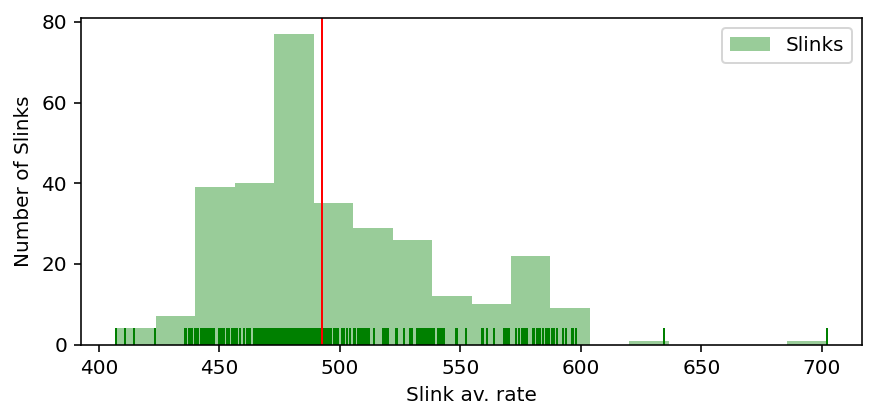

In [8]:
GK={}
for j in Slink:
    GK[j]=0
    for ilist,var in zip(L1_Swap,L2_Swap):
        GK[j]+=sum([ L3[int(i)]*var[i, j].value for i in ilist ])
    #GK[j] = sum([ singleGBTRates_3[int(i)]*model.GKSingles3[i, j].value for i in Single3 ])+sum([ singleGBTRates_2[int(i)]*model.GKSingles2[i, j].value for i in Single2 ]) + sum([ singleGBTRates_1[int(i)]*model.GKSingles1[i, j].value for i in Single1 ]) + sum([ doubleGBTRates_1[int(i)]*model.GKDoubles1[i, j].value for i in Double1 ])  
#print(GK)
#for j in Slink:
    #print(GK[j])
slink_rate_list=[]
for j in GK:
    slink_rate_list.append(GK[j])
    #slink_rate_list
f, ax = plt.subplots(figsize=(7, 3))
sns.distplot(
    slink_rate_list,
    kde=False,
    label='Slinks',
    color='g',
    rug=True,
    )
plt.legend()
ax.set(xlabel='Slink av. rate', ylabel='Number of Slinks')
plt.axvline(linewidth=1, color='r',x=totalRate / nSlinks)
#plt.savefig('312 even_after better odd_.png')

In [12]:
''''def SwapModule2(slinks,SlinkAve,L1_Swap,L2_Swap):
    ss=[i for i in {k: v for k, v in sorted(slinks.items(), key=lambda item: item[1],reverse=True)}.items()]
    lowC=-1
    for i in ss: # i -- slink id s
        if len(i[1][1])==1:
            continue
            
        slinkHigh=i #[çünkü ss high göre sort edilmiş slink dict]
        slinkLow=ss[lowC] #[haliyle bu da en düşük rated slink oluyor]
        sub_li=[]
        sorted_sub_li=[]
    
        print(slinkHigh)
        print(slinkLow)
        dif=float(slinkHigh[1][0])-float(slinkLow[1][0])
        temp=0
        flag=0
        for l in slinkHigh[1][1]:
            #print(l)
            for k in slinkLow[1][1]:
                if abs(float(l[1])-float(k[1]))<dif/2 and float(l[1])>float(k[1]):
                    #print('khmkmh')
                    temp=abs(float(l[1])-float(k[1]))
                    lphigh=l[0]
                    lplow=k[0]
                    flag=1
                else:
                    continue
        if flag==1:
            for ilist,var in zip(L1_Swap,L2_Swap):
                if str(lphigh) in ilist: #and str(lplow)
                    var[str(lphigh),slinkHigh[0]].value=0
                    var[str(lphigh),slinkLow[0]].value=1
                for ilist,var in zip(L1_Swap,L2_Swap):
                    if str(lplow) in ilist:
                        var[str(lplow),slinkLow[0]].value=0
                        var[str(lplow),slinkHigh[0]].value=1
                    #print(str(lphigh))
                    #print(str(lplow))
                #elif str(lplow) in ilist:
                    #var[str(lplow),slinkLow[0]].value=0
                    #var[str(lplow),slinkHigh[0]].value=1
                else:
                    continue
            
            print("-------------OK--------------")
        print("-----------------------------")
        lowC-=1

In [9]:
#BETTER ONE# 
def SwapModule2(slinks,SlinkAve,L1_Swap,L2_Swap):#BURAYA IYI BAK! REDISTRUBTION ALGORITMASINA DA BAK
    ss=[i for i in {k: v for k, v in sorted(slinks.items(), key=lambda item: item[1],reverse=True)}.items()]
    lowC=-1
    highC=0
    #temp_low=lowC
    for i in ss: # i -- slink id s
        if len(i[1][1])==1:
            continue
            
        slinkHigh=ss[highC] #[çünkü ss high göre sort edilmiş slink dict]
        slinkLow=ss[lowC] #[haliyle bu da en düşük rated slink oluyor]
        sub_li=[]
        sorted_sub_li=[]
    
        print(slinkHigh)
        print(slinkLow)
        dif=float(slinkHigh[1][0])-float(slinkLow[1][0])
        temp=0
        flag=0
        temp_best=1000000
        #for s in ss:
            #if s!=slinkHigh:
            #slinkLow=s
        for l in slinkHigh[1][1]:

                #print(l)
            for k in slinkLow[1][1]:
                    
                if abs(float(l[1])-float(k[1]))<dif/2 and float(l[1])>float(k[1]): #and abs(GKavSlinkRate-abs(float(l[1])-float(k[1])))<temp_best:
                    #temp_best=abs(GKavSlinkRate-abs(float(l[1])-float(k[1]))
                        #temp=abs(float(l[1])-float(k[1]))
                    lphigh=l[0]
                    lplow=k[0]
                    flag=1
                else:
                    continue
        if flag==0:
            lowC-=1
                
            #lowC-=1
            #slinkLow=ss[lowC]
        if flag==1:
            #lowC=temp_low
            highC+=1
            lowC-=1                      
            for ilist,var in zip(L1_Swap,L2_Swap):
                if str(lphigh) in ilist: #and str(lplow)
                    var[str(lphigh),slinkHigh[0]].value=0
                    var[str(lphigh),slinkLow[0]].value=1
                for ilist,var in zip(L1_Swap,L2_Swap):
                    if str(lplow) in ilist:
                        var[str(lplow),slinkLow[0]].value=0
                        var[str(lplow),slinkHigh[0]].value=1
                    #print(str(lphigh))
                    #print(str(lplow))
                #elif str(lplow) in ilist:
                    #var[str(lplow),slinkLow[0]].value=0
                    #var[str(lplow),slinkHigh[0]].value=1
                else:
                    continue
            
            #ss=[i for i in {k: v for k, v in sorted(slinks.items(), key=lambda item: item[1],reverse=True)}.items()]
            print("-------------OK--------------")
        print("-----------------------------")
        #lowC-=1
        

In [35]:
def swapData():
    GK={}
    for j in Slink:
        GK[j]=[0,[]]
        for ilist,var in zip(L1_Swap,L2_Swap):
            for i in ilist:
                if var[i, j].value>0.1:
                    GK[j][0] += L3[int(i)]*var[i,j].value #[slink total rate]
                    GK[j][1].append([int(i),L3[int(i)]]) #appen([int(lpgbt id)] , lpgbt Rate)])
    return GK

SwapModule2(swapData(),GKavSlinkRate,L1_Swap,L2_Swap)

('99', [650.86766, [[335, 120.4824], [568, 170.2679], [1071, 67.79069999999999], [1240, 91.34956000000001], [659, 54.0515], [1040, 55.3501], [1361, 12.6002], [1349, 12.9256], [1390, 20.3816], [1098, 45.6681]]])
('286', [407.26460000000003, [[30, 407.26460000000003]]])
-----------------------------
('99', [650.86766, [[335, 120.4824], [568, 170.2679], [1071, 67.79069999999999], [1240, 91.34956000000001], [659, 54.0515], [1040, 55.3501], [1361, 12.6002], [1349, 12.9256], [1390, 20.3816], [1098, 45.6681]]])
('287', [410.867, [[160, 410.867]]])
-----------------------------
('99', [650.86766, [[335, 120.4824], [568, 170.2679], [1071, 67.79069999999999], [1240, 91.34956000000001], [659, 54.0515], [1040, 55.3501], [1361, 12.6002], [1349, 12.9256], [1390, 20.3816], [1098, 45.6681]]])
('291', [414.62500000000006, [[98, 414.62500000000006]]])
-----------------------------
('99', [650.86766, [[335, 120.4824], [568, 170.2679], [1071, 67.79069999999999], [1240, 91.34956000000001], [659, 54.0515], 

In [36]:
print("Average Slink Rate:", GKavSlinkRate)
print("Std: ", value(model.objective))
model.objective.display()

Average Slink Rate: 492.60500217948777
Std:  21.27638944760493
objective : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 21.27638944760493


In [37]:
##### SWAP #######
Vars= {}
Slink=[]
for v in model.component_objects(pyo.Var, active=True):
    #print("Variable",v) 
    lpList=[]
    if v.name.startswith('GKSingles') or v.name.startswith('GKDoubles'):
        for index in v:
        #print ("   ",index, pyo.value(v[index]))
            if index[0] not in lpList:
                lpList.append(index[0])
                #print(index[0])
        Vars[v.name]=[lpList,v] # doctest: +SKIP
    elif v.name.startswith('GKSlinks'):
        for index in v:
            if index[0] not in Slink:
                Slink.append(index[0])

In [38]:
L1_Swap=[]
L2_Swap=[]
for k, v in Vars.items():
    L1_Swap.append(v[0])
    L2_Swap.append(v[1])
    #print(v[1])
L3=SizeSortedRates.set_index('DAQlpGBT')["EvSize"].to_dict()
totalRate = sum([i for i in L3.values()])
nSlinks=len(Slink)
GKavSlinkRate = (totalRate/nSlinks)


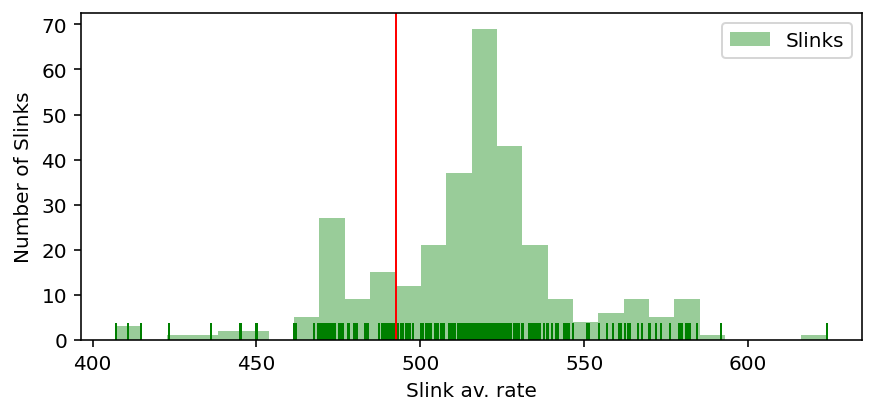

In [39]:
GK={}
for j in Slink:
    GK[j]=0
    for ilist,var in zip(L1_Swap,L2_Swap):
        GK[j]+=sum([ L3[int(i)]*var[i, j].value for i in ilist ])
    #GK[j] = sum([ singleGBTRates_3[int(i)]*model.GKSingles3[i, j].value for i in Single3 ])+sum([ singleGBTRates_2[int(i)]*model.GKSingles2[i, j].value for i in Single2 ]) + sum([ singleGBTRates_1[int(i)]*model.GKSingles1[i, j].value for i in Single1 ]) + sum([ doubleGBTRates_1[int(i)]*model.GKDoubles1[i, j].value for i in Double1 ])  
#print(GK)
#for j in Slink:
    #print(GK[j])
slink_rate_list=[]
for j in GK:
    slink_rate_list.append(GK[j])
    #slink_rate_list
f, ax = plt.subplots(figsize=(7, 3))
sns.distplot(
    slink_rate_list,
    kde=False,
    label='Slinks',
    color='g',
    rug=True,
    )
plt.legend()
ax.set(xlabel='Slink av. rate', ylabel='Number of Slinks')
plt.axvline(linewidth=1, color='r',x=totalRate / nSlinks)
#plt.savefig('312 even_after better odd_.png')

In [24]:
print("Average Slink Rate:", GKavSlinkRate)
print("Std: ", value(model.objective))
model.objective.display()

Average Slink Rate: 492.60500217948777
Std:  5.6616131395827916
objective : Size=1, Index=None, Active=True
    Key  : Active : Value
    None :   True : 5.6616131395827916


In [17]:
with open('./lows26FPGA_run2_part_thershold600_medium4_7pkl_evenS_1.pkl', mode='wb+') as file:
    cloudpickle.dump(model, file)